<a href="https://colab.research.google.com/github/LxMera/Deep-Learning---denoising-rs-fMRI/blob/master/Get_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import os.path as path
if path.exists('Data'):   
    print ('The folder already exists')
else:
    !wget -nc https://www.dropbox.com/s/0mfhfsl137dchs4/DataFix.mat?dl=1
    !wget -nc https://www.dropbox.com/s/9vfa4ehuhu76jjl/Data.zip?dl=1
    !unzip Data.zip?dl=1 | awk 'BEGIN { ORS = "" } { print "|" }'
    !rm -r Data.zip?dl=1
    !mv DataFix.mat?dl=1 Data/DataFix.mat

The folder already exists


In [78]:
!pip install spectrum

In [0]:
import numpy as np
import math
import scipy.io
from scipy.stats import kurtosis 
import matplotlib.pyplot as plt
import cv2
from scipy.fftpack import fft
from spectrum import pmtm
from scipy import signal

In [0]:
def nextpow2(i):
    p=1
    while True:
        if 2**p >= i:
            break
        else:
            p=p+1
    return p

In [0]:
def ALFF_fALFF(slow, ASamplePeriod, nDimTimePoints, AllVolume, plots=False):
    row,col=np.shape(AllVolume)
    #slow2, slow3, slow4 and slow5
    SlowHigh=[0.25, 0.198, 0.073, 0.027]
    SlowLow=[0.198, 0.073, 0.027, 0.01]

    HighCutoff=SlowHigh[slow] #the High edge of the pass band
    LowCutoff=SlowLow[slow]   #the low edge of the pass band
    
    sampleFreq 	 = 1/ASamplePeriod
    sampleLength = nDimTimePoints
    paddedLength = 2**(nextpow2(sampleLength))
    
    if (LowCutoff >= sampleFreq/2): # All high included
        idx_LowCutoff = paddedLength/2 + 1;
    else: # high cut off, such as freq > 0.01 Hz
        idx_LowCutoff = math.ceil(LowCutoff * paddedLength * ASamplePeriod + 1);
    # Change from round to ceil: idx_LowCutoff = round(LowCutoff *paddedLength *ASamplePeriod + 1);

    if (HighCutoff>=sampleFreq/2)and(HighCutoff==0):# All low pass
        idx_HighCutoff = paddedLength/2 + 1;
    else: #Low pass, such as freq < 0.08 Hz
        idx_HighCutoff =  np.fix (HighCutoff *paddedLength *ASamplePeriod + 1);
    # Change from round to fix: idx_HighCutoff	=round(HighCutoff *paddedLength *ASamplePeriod + 1);
    #Zero Padding
    a = np.zeros((paddedLength - sampleLength,len(AllVolume[2])))
    AllVolume = np.concatenate((AllVolume, a), axis=0)
    
    
    print('\t Performing FFT ...');
    
    AllVolume=np.transpose(AllVolume)
    AllVolume = 2*np.true_divide(abs(scipy.fft(AllVolume)),sampleLength);
    AllVolume=np.transpose(AllVolume)
    
    print('Calculating ALFF for slow', slow+2,' ...')    
    ALFF_2D = np.mean(AllVolume[idx_LowCutoff:int(idx_HighCutoff)], axis=0)
    
    print('Calculating fALFF for slow', slow+2,' ...')
    num = np.sum(AllVolume[(idx_LowCutoff):int(idx_HighCutoff)],axis=0,dtype=float)
    den = np.sum(AllVolume[2:int(paddedLength/2 + 1)],axis=0,dtype=float)
    fALFF_2D =  num/den
       
    metricas = np.concatenate((ALFF_2D, fALFF_2D), axis=0).reshape((2,col))
    
    if plots:
        plt.figure()
        plt.title('Power Spectral Density')
        freq=np.arange(0.0, 1/ASamplePeriod, 1/(ASamplePeriod*np.shape(AllVolume)[0]))
        plt.plot(freq,AllVolume)
        
        plt.figure()
        plt.title('ALFF')
        plt.plot(metricas[0,:])
        
        plt.figure()
        plt.title('fALFF')
        plt.plot(metricas[1,:]) 
    
    return metricas

In [0]:
def Multitaper(Dx, shw=False):
    #print('Multitaper...')
    if shw:
        plt.figure()
        plt.title('Multitaper')
    if np.shape(np.shape(Dx))[0]==1:
        Sk_complex , weights , _ = pmtm(Dx, NW=2.5, k=5, show=shw)
        Sk = abs(Sk_complex)**2;
        Sk = Sk.transpose();
        Sk = np.mean(Sk * weights, axis=1);
    else:
        sign=np.shape(Dx)[1]
        Sk=[]
        for i in range(sign):
            Sk_complex , weights , _ = pmtm(Dx[:,i], NW=2.5, k=5, show=shw)
            Sk0 = abs(Sk_complex)**2;
            Sk0 = Sk0.transpose();
            Sk.append(np.mean(Sk0 * weights, axis=1))
        Sk=np.transpose(Sk)
    return Sk

In [0]:
def periodogram(y, fx):
  fy, px = signal.periodogram(y, fx, axis=0)
  return px, fy

In [0]:
def MNF(y, fs):
    print('Calculating Mean frequency...')
    px, fy=periodogram(y, fs)
    y=np.dot(fy,px)/np.sum(px, axis=0)     
    return y

In [0]:
def MDF(y, fs):
    print('Calculating Median frequency...')
    px, fy=periodogram(y, fs)

    suma=np.sum(px, axis=0)/2
    sumc=np.cumsum(px, axis=0)

    indx=[]
    for i in range(np.shape(y)[1]):
      indx.append(np.sum(sumc[:,i]<suma[i]))
    f=fy[indx]
    return f

In [0]:
def TTP(y, fs):
    print('Calculating Total power...')
    px, fy=periodogram(y, fs)
    y=np.sum(px, axis=0)
    return y

In [0]:
def MNP(y, fs):
    print('Calculating Mean Power...')
    px, fy=periodogram(y, fs)
    y=np.sum(px, axis=0)/len(px)
    return y

In [0]:
def PKF(y, fs):
    print('Calculating Peak frequency...')
    #print('frecuencia maxima')
    px, fy=periodogram(y, fs)
    ym=np.argmax(px, axis=0)
    indx=fy[ym]
    return indx

In [0]:
def SM(y, fs, n, tx=True):
    if tx:
      print('Calculating Spectral moment of order ',n,' ...')
    px, fy=periodogram(y, fs)
    y=np.dot(fy**n,px)/np.sum(px, axis=0)
    return y

In [0]:
def PSR(y, n0=1):
    print('Calculating Power spectrum ration...')
    px, fy=periodogram(y, fs)
    indx=np.argmax(px, axis=0)
    mask=np.zeros(np.shape(px))
    for i in range(np.shape(px)[1]):
      mask[indx[i],i]=1
    kernel=np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]], np.dtype('uint8'))
    mask=cv2.dilate(mask, kernel, iterations=n0)
    pmx=mask*px
    y=np.sum(pmx, axis=0)
    yt=np.sum(px, axis=0)
    return y/yt

In [0]:
def VCF(y, fs):
    print('Calculating Variance of central frequency...')
    sm0=SM(y, fs, 0, False)
    sm1=SM(y, fs, 1, False)
    sm2=SM(y, fs, 2, False)
    vc=(sm2/sm0) -((sm1/sm0)**2)
    return vc

In [0]:
def freq(y, fs):
  print('Calculating Kurtosis...')
  krt=kurtosis(y, axis=0)
  print('Calculating Mean...')
  media=np.mean(y, axis=0)
  print('Calculating Median...')
  mediana=np.median(y, axis=0)

  px, fy=periodogram(y, fs)
  print('Calculating Entropy...')
  entropy=-np.sum(px*np.log(px+0.0001), axis=0)  

  print('Calculating Negentropy...')
  negentropy=((np.mean(y**3))**2)+(krt**2)

  print('Calculating Jump function 1...')
  Jump1=np.max(np.abs(np.diff(y, axis=0)*fs), axis=0)/np.std(y, axis=0)
  print('Calculating Jump function 2...')
  Jump2=np.max(np.abs(np.diff(y, axis=0)*fs), axis=0)/np.std(np.abs(np.diff(y, axis=0)*fs), axis=0)
  print('Calculating Jump function 3...')
  Jump3=np.mean(np.abs(np.diff(y, axis=0)*fs), axis=0)/np.std(y, axis=0)
  fre=np.array([krt, media, mediana, entropy, negentropy, Jump1, Jump2, Jump3])
  return fre  

In [0]:
def get_AllMetrics(y,t,point):
  alff2=ALFF_fALFF(0,t, point, y, False)
  alff3=ALFF_fALFF(1,t, point, y, False)
  alff4=ALFF_fALFF(2,t, point, y, False)
  alff5=ALFF_fALFF(3,t, point, y, False)
  fr=freq(y, 1/t)

  ###
  fs=1/t

  print('Calculating Mean frequency...')
  px, fy=periodogram(y, fs)
  mnf=np.dot(fy,px)/np.sum(px, axis=0)     
  
  print('Calculating Median frequency...')
  suma=np.sum(px, axis=0)/2
  sumc=np.cumsum(px, axis=0)
  indx=[]
  for i in range(np.shape(y)[1]):
    indx.append(np.sum(sumc[:,i]<suma[i]))
  mdf=fy[indx]

  print('Calculating Total power...')
  ttp=np.sum(px, axis=0)

  print('Calculating Mean Power...')
  mnp=np.sum(px, axis=0)/len(px)

  print('Calculating Peak frequency...')
  indx=np.argmax(px, axis=0)
  pk=fy[indx]

  print('Calculating Spectral moment of order 1 ...')
  sm1=np.dot(fy**1,px)/np.sum(px, axis=0)
  
  print('Calculating Spectral moment of order 2 ...')
  sm2=np.dot(fy**2,px)/np.sum(px, axis=0)

  print('Calculating Spectral moment of order 3 ...')
  sm3=np.dot(fy**3,px)/np.sum(px, axis=0)

  print('Calculating Power spectrum ration...')
  mask=np.zeros(np.shape(px))
  for i in range(np.shape(px)[1]):
    mask[indx[i],i]=1
  kernel=np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]], np.dtype('uint8'))
  mask=cv2.dilate(mask, kernel, iterations=3)
  pmx=mask*px
  y=np.sum(pmx, axis=0)
  yt=np.sum(px, axis=0)
  psr=y/yt

  print('Calculating Variance of central frequency...')
  vcf=(sm2/mnf) -((sm1/mnf)**2)

  #Ordenar
  alff=np.array([alff2[0,:], alff3[0,:], alff4[0,:], alff5[0,:]])
  falff=np.array([alff2[1,:], alff3[1,:], alff4[1,:], alff5[1,:]])  
  fr2=np.array([mnf, mdf, ttp, mnp, pk, sm1, sm2, sm3, psr, vcf])

  metrics=np.concatenate((alff, falff, fr, fr2), axis=0)
  return np.transpose(metrics)

	 Performing FFT ...
Calculating ALFF for slow 2  ...
Calculating fALFF for slow 2  ...
	 Performing FFT ...
Calculating ALFF for slow 3  ...
Calculating fALFF for slow 3  ...
	 Performing FFT ...
Calculating ALFF for slow 4  ...
Calculating fALFF for slow 4  ...
	 Performing FFT ...
Calculating ALFF for slow 5  ...
Calculating fALFF for slow 5  ...
Calculating Kurtosis...
Calculating Mean...
Calculating Median...
Calculating Entropy...
Calculating Negentropy...
Calculating Jump function 1...
Calculating Jump function 2...
Calculating Jump function 3...
Calculating Mean frequency...
Calculating Median frequency...
Calculating Total power...
Calculating Mean Power...
Calculating Peak frequency...
Calculating Spectral moment of order 1 ...
Calculating Spectral moment of order 2 ...
Calculating Spectral moment of order 3 ...
Calculating Power spectrum ration...
Calculating Variance of central frequency...
(22877, 26)


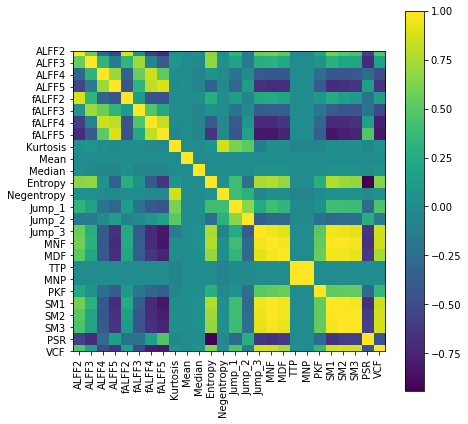

In [94]:
if __name__=="__main__":
    #Main script
    data = scipy.io.loadmat('Data/DataFix.mat')    
    DataS=data['series']
    
    TR=0.7;
    TimePoints=1200;
    
    metricas=get_AllMetrics(DataS,TR,TimePoints)
    print(np.shape(metricas))

    lab=['ALFF2','ALFF3','ALFF4','ALFF5','fALFF2','fALFF3','fALFF4','fALFF5','Kurtosis','Mean','Median','Entropy','Negentropy','Jump_1','Jump_2','Jump_3','MNF','MDF','TTP','MNP','PKF','SM1','SM2','SM3','PSR','VCF']
    tic=np.arange(26)
    corr=np.corrcoef(np.transpose(metricas))
    plt.figure(figsize=(7,7))
    plt.imshow(corr)
    plt.xticks(tic, lab, rotation='vertical')
    plt.yticks(tic, lab)
    plt.colorbar()

    np.shape(metricas)
    scipy.io.savemat('drive/My Drive/DatosXY.mat', {'Datos_C': metricas})